## What is vector search?

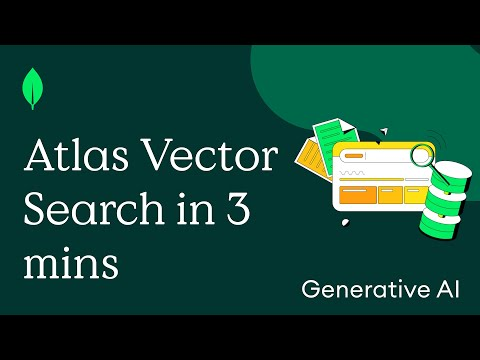

In [1]:
from IPython.display import YouTubeVideo, display

video_id = 'DUxUW0Kg7JM'
video = YouTubeVideo(video_id)
display(video)

# Link: https://www.youtube.com/watch?v=bBA9rUdqmgY


## Run vector search queries

Reference: 
1. https://www.mongodb.com/docs/atlas/atlas-vector-search/vector-search-stage/

2. https://www.mongodb.com/library/vector-search/building-generative-ai-applications-using-mongodb?lb-mode=overlay

In [ ]:
""" Connecting to database"""


import pymongo

client = pymongo.MongoClient("<Your MongoDB URI>")
db = client.sample_mflix
collection = db.movies

In [ ]:
""" Setting up the embedding creation function"""

import requests

hf_token = "<your_huggingface_token>"
embedding_url = "https://api-inference.huggingface.co/pipeline/feature-extraction/sentence-transformers/all-MiniLM-L6-v2"

def generate_embedding(text: str) -> list[float]:
    response = requests.post(
        embedding_url,
        headers={"Authorization": f"Bearer {hf_token}"},
        json={"inputs": text})
    if response.status_code != 200:
        raise ValueError(f"Request failed with status code {response.status_code}: {response.text}")
    return response.json()


generate_embedding("MongoDB is awesome")

## Create and store embeddings

In [ ]:
for doc in collection.find({'plot':{"$exists": True}}).limit(50):
	doc['plot_embedding_hf'] = generate_embedding(doc['plot'])
	collection.replace_one({'_id': doc['_id']}, doc)

## Create and store vector search index

Now, we will head over to Atlas Search and create an index. First, click the “search” tab on your cluster and click on “Create Search Index.”

This will lead to the “Create a Search Index” configuration page. Select the “JSON Editor” and click “Next.”

Now, perform the following three steps on the "JSON Editor" page:
Select the database and collection on the left. For this tutorial, it should be sample_mflix/movies.
Enter the Index Name. For this tutorial, we are choosing to call it PlotSemanticSearch.
Enter the configuration JSON (given below) into the text editor. The field name should match the name of the embedding field created in Step 3 (for this tutorial it should be plot_embedding_hf), and the dimensions match those of the chosen model (for this tutorial it should be 384). The chosen value for the "similarity" field (of “dotProduct”) represents cosine similarity, in our case.

Then, click “Next” and click “Create Search Index” button on the review page.

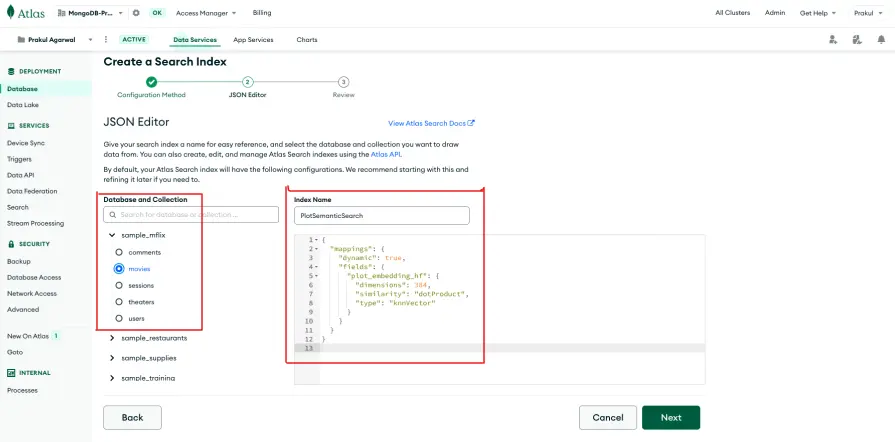

In [ ]:
{
    "mappings": {
        "dynamic": true,
        "fields": {
            "plot_embedding_hf": {
                "dimensions": 384,
                "similarity": "dotProduct",
                "type": "knnVector"
            }
        }
    }
}

## Query your data

In [ ]:
query = "imaginary characters from outer space at war"

results = collection.aggregate([
  {"$vectorSearch": {
    "queryVector": generate_embedding(query),
    "path": "plot_embedding_hf",
    "numCandidates": 100,
    "limit": 4,
    "index": "PlotSemanticSearch",
      }}
});

for document in results:
    print(f'Movie Name: {document["title"]},\nMovie Plot: {document["plot"]}\n')